## In this notebook:
- Select channels which are most heritable and correlated with N status
- Model N with an index made from selected channels. Report MSE and R^2

In [1]:
from sys import stdout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Load notebook and select our subsets
# df should point to ScansNutesAll
df = pd.read_csv(r'SomeFolders/../ScansNutesALL.csv')
df = df[(df['Year'] == 2020) | (df['Year'] == 2022) & (df['Field'] == 'BLove')]


# A little QC: look at spectras 

Index(['453', '455', '456', '457', '459', '460', '461', '463', '464', '465',
       ...
       '925', '926', '928', '929', '930', '932', '933', '934', '936', '937'],
      dtype='object', length=364)


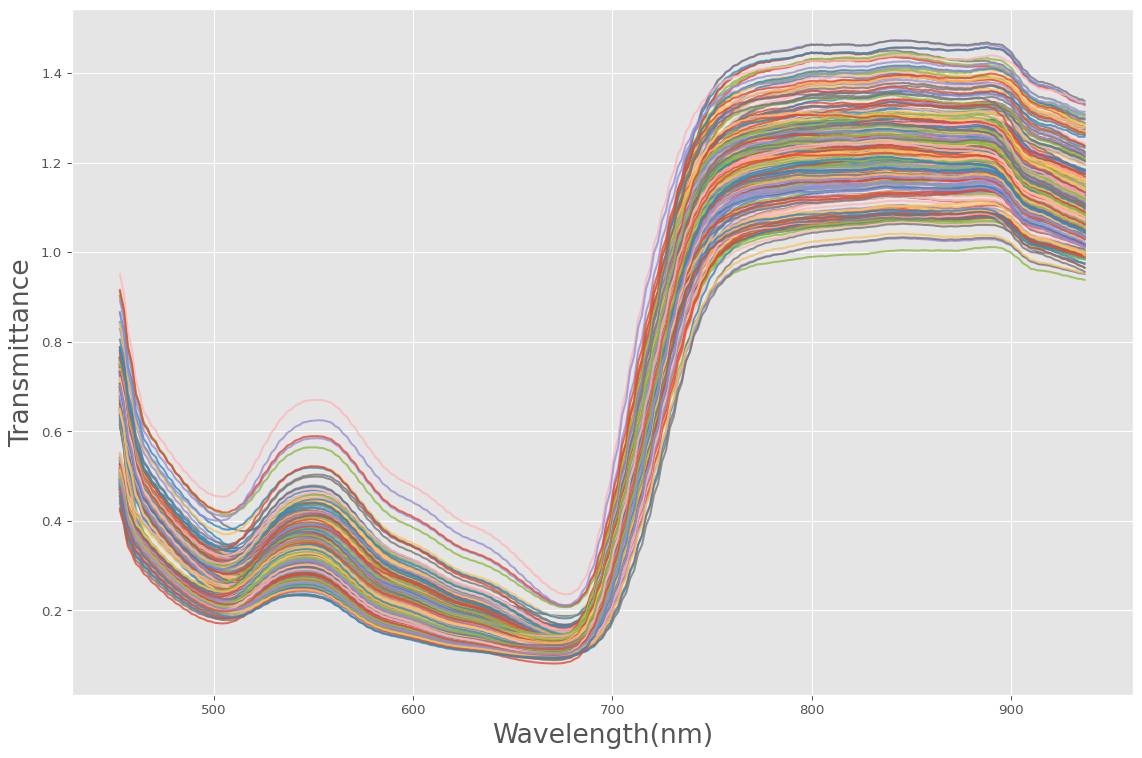

In [3]:
# Columns should be 453 to 937 and len of 364
print(df.columns[28:392])
# Take a slice of the spectra, should be 364 bands starting with 453 and ending at 937
wavelengths = df.columns[28:392].astype(int)
spectra = df.iloc[:,28:392].values
# First make a plot of all raw
fig = plt.figure(figsize=(12, 8), dpi=96)
with plt.style.context('ggplot'):
    plt.plot(wavelengths, spectra.T, alpha = 0.8)
    plt.xlabel('Wavelength(nm)', fontsize = 20)
    plt.ylabel('Transmittance', fontsize = 20)
    plt.tight_layout()
    plt.show()

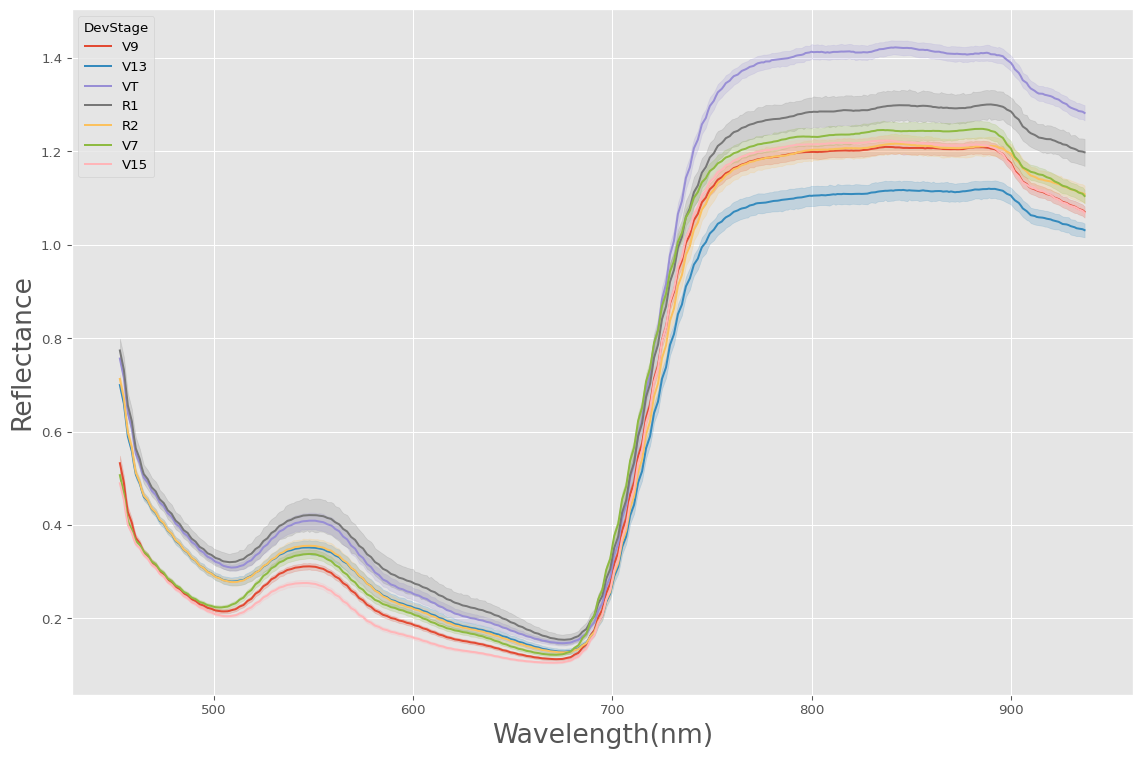

In [6]:
# Lets plot by some predictor variables
# Next make a graph of spectra by date and treatment need to make wavelengths str again
wavelengths = df.columns[28:392].astype(str)
dfmelt = df.melt(id_vars=['Plot', 'Block', 'Year', 'DateSampled', 'Hybrid', 'DevStage', 'Treatment1', 'Treatment2'],
                 value_vars=wavelengths, value_name = 'Transmittance', var_name='Wavelength')


dfmelt['Wavelength'] = dfmelt['Wavelength'].astype(int)

fig = plt.figure(figsize=(12, 8), dpi=96)
with plt.style.context('ggplot'):
    sns.lineplot(data=dfmelt, x='Wavelength', y='Transmittance', hue='DevStage', ci=95)
    plt.xlabel('Wavelength(nm)', fontsize = 20)
    plt.ylabel('Reflectance', fontsize = 20)
    plt.tight_layout()
    plt.show()

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
def anova_table(aov):
    aov['mean_sq'] = aov.sum_sq/aov.df
    meansqsum = aov.mean_sq.sum()
    aov['heritability'] = aov.mean_sq/meansqsum
    cols = ['sum_sq', 'df', 'mean_sq', 'heritability', 'F', 'PR(>F)']
    aov = aov[cols]
    return aov

heris = []
for n in wavelengths:
    n = "Q('" + n +"')"
    print(n)
    formula = n + '~ Hybrid + DateSampled'
    model = ols(formula = formula, data = df).fit()
    aov = sm.stats.anova_lm(model, type = 3)
    print(anova_table(aov))
    heris.append(anova_table(aov)['heritability'][0])

Q('453')
               sum_sq     df   mean_sq  heritability           F  \
Hybrid       3.688027   25.0  0.147521      0.742148  120.155741   
DateSampled  0.400215    8.0  0.050027      0.251675   40.746871   
Residual     0.324126  264.0  0.001228      0.006177         NaN   

                    PR(>F)  
Hybrid       6.775689e-129  
DateSampled   5.493292e-42  
Residual               NaN  
Q('455')
               sum_sq     df   mean_sq  heritability           F  \
Hybrid       3.506098   25.0  0.140244      0.711012  122.671555   
DateSampled  0.446867    8.0  0.055858      0.283192   48.859387   
Residual     0.301817  264.0  0.001143      0.005796         NaN   

                    PR(>F)  
Hybrid       5.575852e-130  
DateSampled   7.181411e-48  
Residual               NaN  
Q('456')
               sum_sq     df   mean_sq  heritability           F  \
Hybrid       3.235316   25.0  0.129413      0.682602  120.236798   
DateSampled  0.472787    8.0  0.059098      0.311721   54.9

In [6]:
df1 = pd.DataFrame({'Wavls': wavelengths, 'Heris': heris})
df1['Wavls'] = df1['Wavls'].astype('int')
px.line(df1, x='Wavls', y='Heris')

In [63]:
corrs = []
for n in wavelengths:
    r = np.corrcoef(df['N'], df[n])
    #print(r[0][1])
    corrs.append(r[0][1])
# Turn that list into a dataframe for easy processing
df1 = pd.DataFrame({'Wavelengths': wavelengths, 'PearsonCorrelation': corrs})
df1['Wavelengths'] = df1['Wavelengths'].astype('int')
px.line(df1, x='Wavelengths', y='PearsonCorrelation')

In [40]:
# Calculate NDVI based on lit
df['ndvi_lit'] = (df['800'] - df['651'])/(df['800'] + df['651'])
# Calculate ndvi based on most correlated values
df['ndvi_cor'] = (df['905'] - df['569'])/(df['905'] + df['569'])

In [37]:
px.histogram(df, x='ndvi_cor')

In [47]:
# model N with these bands
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


df_train = df[df['DateSampled'] != '8/4/2020']
df_test = df[df['DateSampled'] == '8/4/2020']
# fraction of test split
print(len(df_test)/len(df))
x_lit = df_train['ndvi_lit'].values.reshape(-1,1)
x_cor = df_train['ndvi_cor'].values.reshape(-1,1)
y_train = df_train['N'].values.reshape(-1,1)
y_test = df_test['N'].values.reshape(-1,1)
x_test_lit = df_test['ndvi_lit'].values.reshape(-1,1)
x_test_cor = df_test['ndvi_cor'].values.reshape(-1,1)
reg_lit = LinearRegression().fit(x_lit, y_train)
print(reg_lit.score(x_lit, y_train))

reg_cor = LinearRegression().fit(x_cor, y_train)
print(reg_cor.score(x_cor, y_train))

predictions_lit = reg_lit.predict(x_test_lit)
predictions_cor = reg_cor.predict(x_test_cor)
r2_lit = r2_score(y_test, predictions_lit)
r2_cor = r2_score(y_test, predictions_cor)
mse_lit = mean_squared_error(y_test, predictions_lit, multioutput='uniform_average')
mse_cor = mean_squared_error(y_test, predictions_cor, multioutput='uniform_average')
print('Score for cor_dvi:', r2_cor, mse_cor)
print('Score for ndvi:',r2_lit, mse_lit)




0.2760942760942761
0.29398084373138245
0.30434121402607117
Score for cor_dvi: 0.412571517397219 0.15991057828424227
Score for ndvi: 0.21372941712665183 0.21403964451649843


Text(0, 0.5, 'GroundTruth: N %')

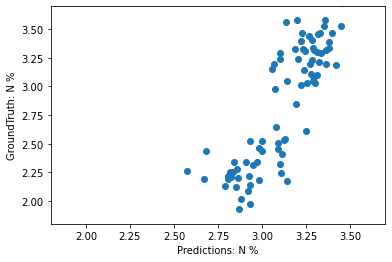

In [60]:
plt.scatter(predictions_lit, y_test)
plt.xlim([1.8, 3.7])
plt.ylim([1.8, 3.7])
plt.xlabel('Predictions: N %')
plt.ylabel('GroundTruth: N %')

Text(0, 0.5, 'GroundTruth: N %')

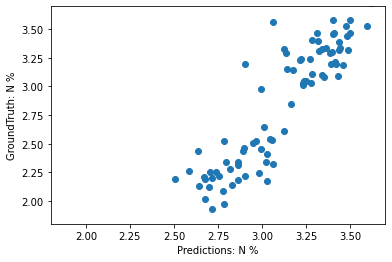

In [59]:
plt.scatter(predictions_cor, y_test)
plt.xlim([1.8, 3.7])
plt.ylim([1.8, 3.7])
plt.xlabel('Predictions: N %')
plt.ylabel('GroundTruth: N %')

# Discussion: 
- Crafting a normalized vegetative band derived from correlations in the data showed increased accuracy compared to established ndvi values. 
